# Análise dos Resultados obtidos durante as iterações do modelo

# Setup

In [29]:
import sys

sys.path.append("..")

from osgeo import gdal

import pandas as pd

import numpy as np

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim

from tqdm import tqdm

from generate_distance_map import generate_distance_map

# load label
from skimage.measure import label, regionprops, regionprops_table

from src.multicropdataset import DatasetFromCoord
from src.utils import read_tiff, read_yaml


# from evaluation import evaluate_iteration
from pred2raster import pred2raster
from sample_selection import get_components_stats

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import seaborn as sns

import os
import gc

from collections.abc import Iterable

from joblib import Parallel, delayed

In [30]:
# increase DPI
plt.rcParams["figure.dpi"] = 120

In [31]:
def autolabel(ax: np.ndarray, format: str = None):
    """
    Attach a text label above each bar in *rects*, displaying its height.
    """
    if not isinstance(ax, Iterable):
        ax = [ax]

    if format is None:
        format = "{:.0f}"

    for ax_ in ax:
        for rect in ax_.patches:
            height = rect.get_height()
            ax_.annotate(
                format.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha="center",
                va="bottom",
            )

In [32]:
sns.set_style("darkgrid")
# set figsize
plt.rcParams["figure.figsize"] = (8, 5)

In [33]:
# dict_colors =
# generate color palette to values from 1 to 14
dict_colors = {}

dict_colors["tree_type"] = {
    key: color for key, color in zip(range(1, 15), sns.color_palette("tab20", 14))
}

# Data loading

In [34]:
args = read_yaml("../args.yaml")

iter_folders = os.listdir(args["data_path"])

iter_folders = [folder for folder in iter_folders if folder.startswith("iter_")]

iter_folders.sort()

iter_folders.pop()

'iter_004'

In [35]:
def get_iter_stats(iter_folder, labels_file="all_labels_set.tif"):
    num_iter = int(iter_folder.split("_")[1])
    if num_iter != 0:
        label_path = os.path.join(
            args["data_path"], iter_folder, "new_labels", labels_file
        )
    else:
        label_path = os.path.join(args["data_path"], args.train_segmentation_path)

    label_img = read_tiff(label_path)

    components = label(label_image = label_img)

    components_stats = get_components_stats(components, label_img)
    components_stats.reset_index(inplace=True)

    iter_num = int(iter_folder.split("_")[1])

    components_stats["iter"] = f"iter_{iter_num:03d}"

    components_stats["iter_num"] = iter_num

    return components_stats

In [36]:
all_iter_stats = Parallel(n_jobs=-1)(
    delayed(get_iter_stats)(iter_folder) for iter_folder in iter_folders
)
all_labels_stats = pd.concat(all_iter_stats)

/home/luiz/multi-task-fcn/1th_version_data/segmentation/samples_A1_train2tif.tif
/home/luiz/multi-task-fcn/1th_version_data/iter_001/new_labels/all_labels_set.tif
/home/luiz/multi-task-fcn/1th_version_data/iter_002/new_labels/all_labels_set.tif
/home/luiz/multi-task-fcn/1th_version_data/iter_003/new_labels/all_labels_set.tif


In [37]:
selected_iter_stats = Parallel(n_jobs=-1)(
    delayed(get_iter_stats)(iter_folder, "selected_labels_set.tif")
    for iter_folder in iter_folders
)
selected_labels_stats = pd.concat(selected_iter_stats)

/home/luiz/multi-task-fcn/1th_version_data/segmentation/samples_A1_train2tif.tif
/home/luiz/multi-task-fcn/1th_version_data/iter_002/new_labels/selected_labels_set.tif
/home/luiz/multi-task-fcn/1th_version_data/iter_001/new_labels/selected_labels_set.tif
/home/luiz/multi-task-fcn/1th_version_data/iter_003/new_labels/selected_labels_set.tif


In [38]:
label_img = read_tiff(os.path.join(args["data_path"], args.train_segmentation_path))

total_area = label_img.shape[0] * label_img.shape[1]

print("Quantidade de pixels na imagem:")
print(f"{total_area:,.0f}")

/home/luiz/multi-task-fcn/1th_version_data/segmentation/samples_A1_train2tif.tif
Quantidade de pixels na imagem:
26,562,510


# Análise da área coberta pela segmentação semântica

In [39]:
last_iter_num = all_labels_stats["iter_num"].max()

last_iter_stats = all_labels_stats[
    all_labels_stats["iter_num"] == all_labels_stats["iter_num"].max()
]

print(
    f"Área coberta pela segmentação semântica, considerando a imagem { label_img.shape}: {last_iter_stats['area'].sum()/total_area:,.2%} da imagem"
)

Área coberta pela segmentação semântica, considerando a imagem (4043, 6570): 4.82% da imagem


## Distribuição da área coberta por cada tipo de árvore

Análise considerando valores absolutos:

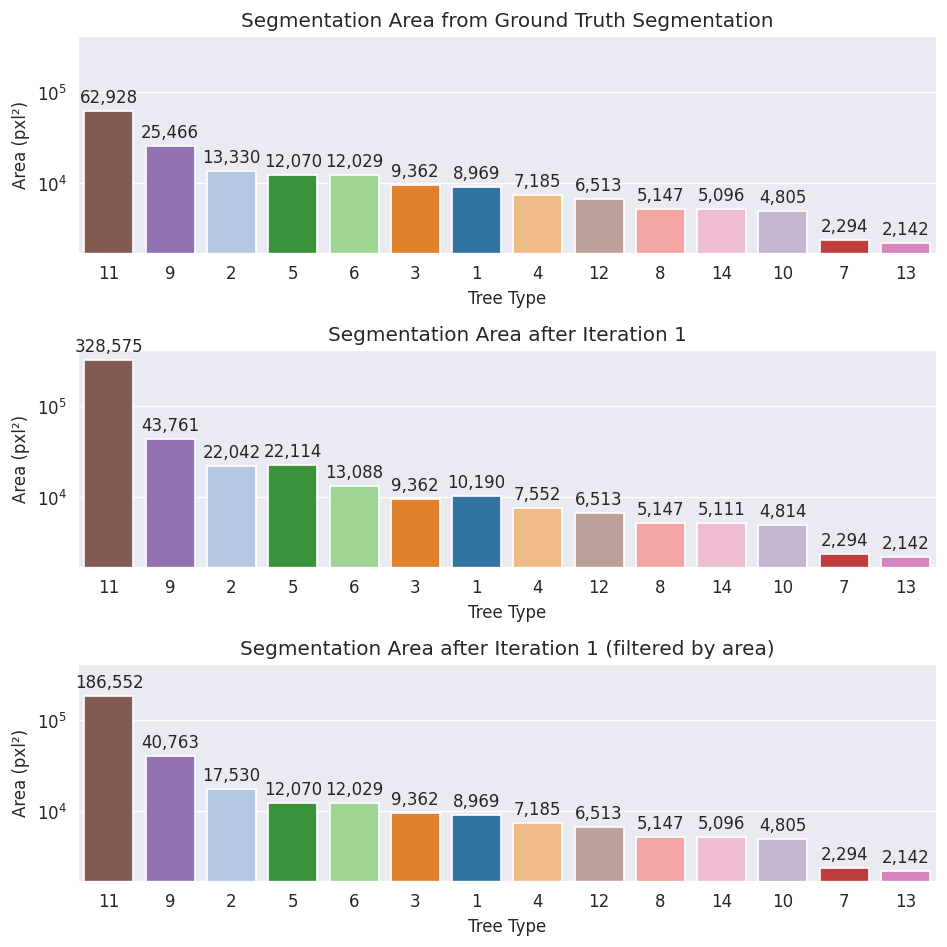

In [40]:
# change fig size
fig, ax = plt.subplots(nrows=3, ncols=1, sharey=True, figsize=(8, 8))
order = all_labels_stats[all_labels_stats["iter_num"] == 0].groupby("tree_type")["area"].sum().sort_values(ascending=False).index


sns.barplot(
    data=all_labels_stats[all_labels_stats["iter_num"] == 0],
    x="tree_type",
    y="area",
    estimator=lambda group: (group.sum()),
    errorbar=None,
    order=order,
    palette=dict_colors["tree_type"],
    log=True,
    ax=ax[0],
)

ax[0].set_title(f"Segmentation Area from Ground Truth Segmentation")
ax[0].set_xlabel("Tree Type")
ax[0].set_ylabel("Area (pxl²)")

autolabel(ax[0], "{:,.0f}")


sns.barplot(
    data=all_labels_stats[all_labels_stats["iter_num"] == 1],
    x="tree_type",
    y="area",
    estimator=lambda group: (group.sum()),
    errorbar=None,
    order=order,
    palette=dict_colors["tree_type"],
    log=True,
    ax=ax[1],
)

ax[1].set_title(f"Segmentation Area after Iteration 1")

ax[1].set_xlabel("Tree Type")
ax[1].set_ylabel("Area (pxl²)")

autolabel(ax[1], "{:,.0f}")


sns.barplot(
    data=selected_labels_stats[selected_labels_stats["iter_num"] == 1],
    x="tree_type",
    y="area",
    estimator=lambda group: (group.sum()),
    errorbar=None,
    order=order,
    palette=dict_colors["tree_type"],
    # log=True,
    ax=ax[2],
)

ax[2].set_title(f"Segmentation Area after Iteration 1 (filtered by area)")

ax[2].set_xlabel("Tree Type")
ax[2].set_ylabel("Area (pxl²)")

autolabel(ax[2], "{:,.0f}")

plt.tight_layout()

plt.show()

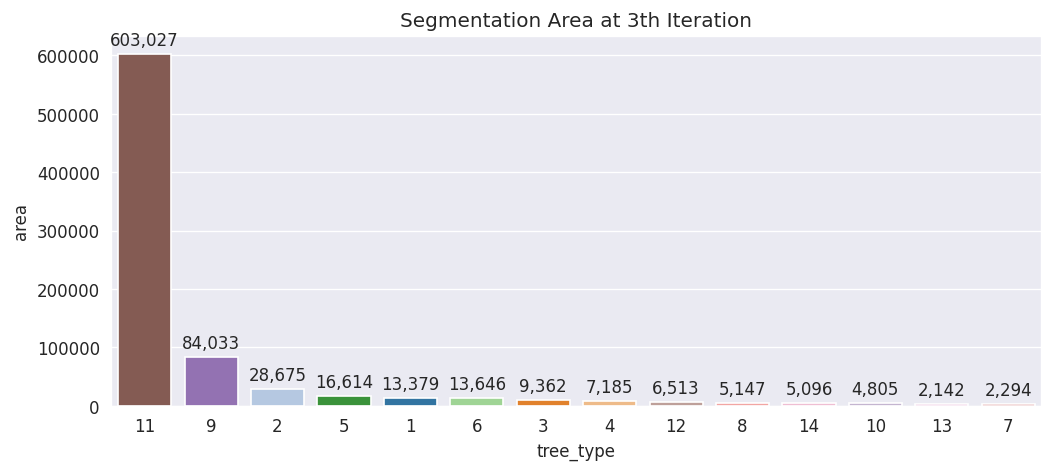

In [41]:
# change fig size
fig = plt.gcf()
fig.set_size_inches(10, 4)

ax = sns.barplot(
    data=selected_labels_stats[selected_labels_stats["iter_num"] == selected_labels_stats["iter_num"].max()],
    x="tree_type",
    y="area",
    estimator=lambda group: group.sum(),
    errorbar=None,
    order=last_iter_stats.groupby("tree_type")["area"]
        .sum()
        .sort_values(ascending=False)
        .index,
    palette=dict_colors["tree_type"],
)


ax.set_title(f"Segmentation Area at {selected_labels_stats['iter_num'].max()}th Iteration")

autolabel(ax, "{:,.0f}")

plt.show()

Agora, em valores relativos ao total da área segmentada:

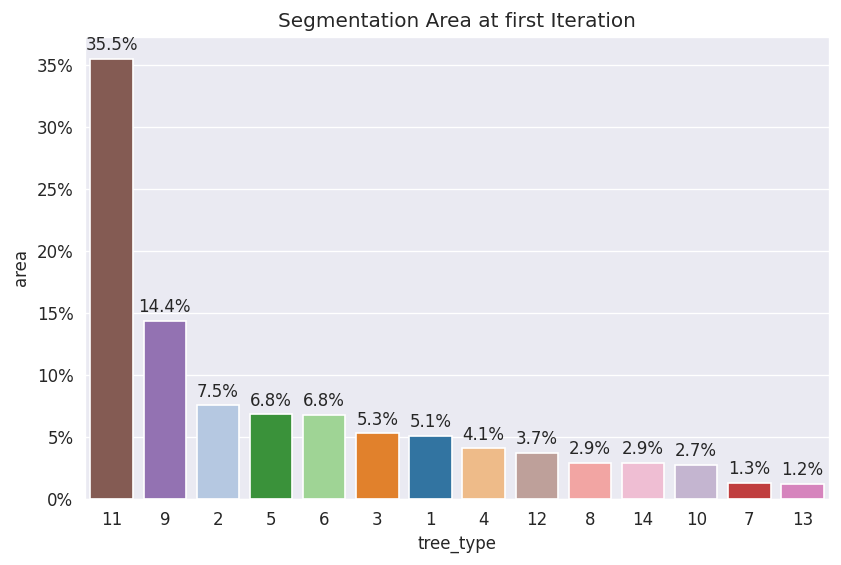

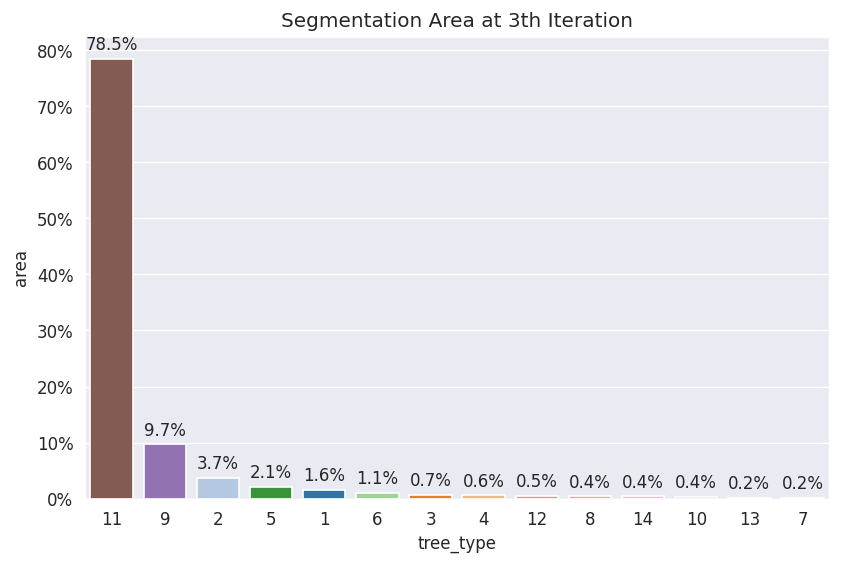

In [42]:
ax = sns.barplot(
    data=all_labels_stats[all_labels_stats["iter_num"] == 0],
    x="tree_type",
    y="area",
    estimator=lambda group: (
        group.sum() / all_labels_stats[all_labels_stats["iter_num"] == 0]["area"].sum()
    ),
    errorbar=None,
    order = all_labels_stats[all_labels_stats["iter_num"] == 0]
            .groupby("tree_type")["area"]
            .sum()
            .sort_values(ascending=False)
            .index,
    palette=dict_colors["tree_type"],
)

ax.set_title(f"Segmentation Area at first Iteration")

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.0%}".format(y)))

autolabel(ax, "{:.1%}")

plt.show()



ax = sns.barplot(
    data=last_iter_stats,
    x="tree_type",
    y="area",
    estimator=lambda group: group.sum() / last_iter_stats["area"].sum(),
    errorbar=None,
    order=last_iter_stats.groupby("tree_type")["area"]
    .sum()
    .sort_values(ascending=False)
    .index,
    palette=dict_colors["tree_type"],
)

ax.set_title(f"Segmentation Area at {last_iter_num}th Iteration")

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.0%}".format(y)))

autolabel(ax, "{:.1%}")

plt.show()

## Evolução Temporal da área segmentada

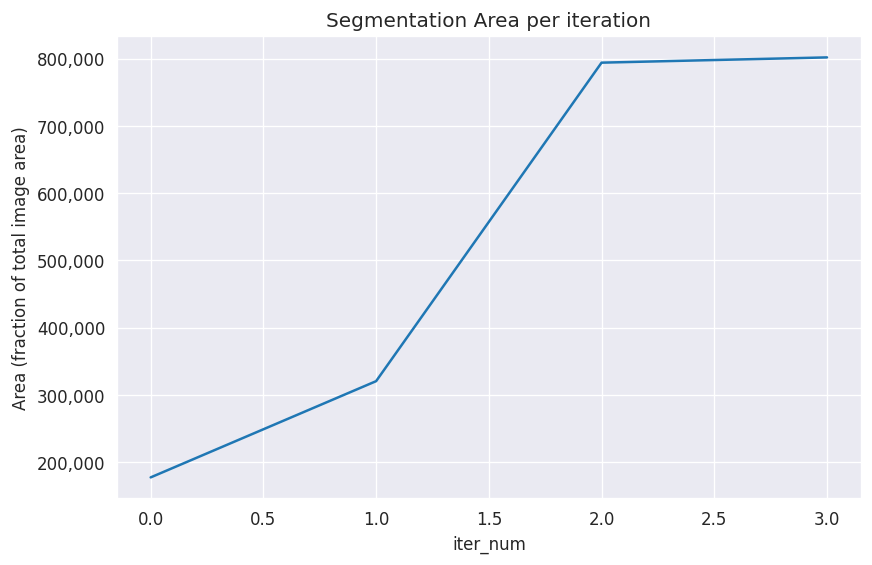

In [43]:
ax = sns.lineplot(
    data=selected_labels_stats,
    x="iter_num",
    y="area",
    estimator=lambda x: x.sum(),
    errorbar=None,
)

ax.set_title("Segmentation Area per iteration")
ax.set_ylabel("Area (fraction of total image area)")

# format y ticks labels with FuncFormatter
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:,.0f}".format(y)))

plt.show()

## Distribuição das áreas das árvores por espécie

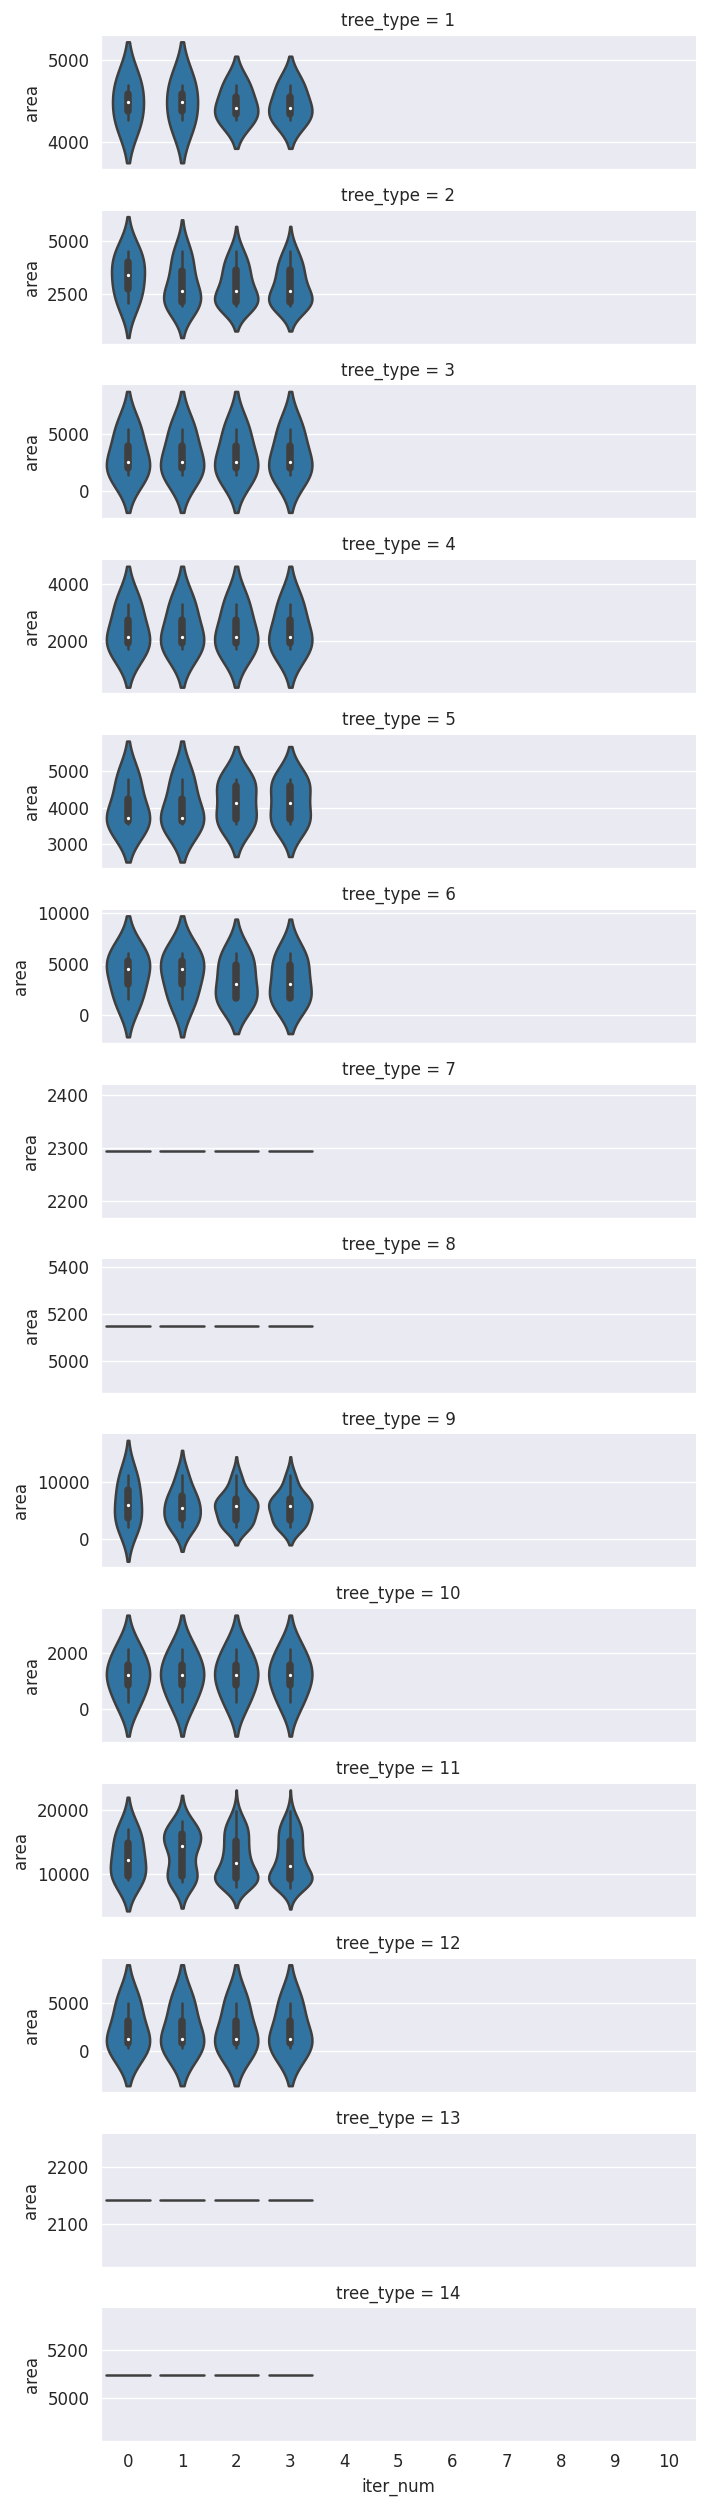

In [44]:
g = sns.FacetGrid(
    selected_labels_stats,
    row="tree_type",
    sharey=False,
    aspect=4,
    height=1.5,
    palette=dict_colors["tree_type"],
)


g.map(sns.violinplot, "iter_num", "area", order=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# set median line
# g.map(sns.lineplot, "iter_num", "area", color="red", estimator=np.median, errorbar=None, marker="o")

In [45]:
print("Evolução da área mínima de cada classe ao longo das iterações")
selected_labels_stats.groupby(
    [
        "tree_type",
        "iter_num",
    ]
)[
    "area"
].min().unstack().style.background_gradient(cmap="Blues", axis=1)

Evolução da área mínima de cada classe ao longo das iterações


iter_num,0,1,2,3
tree_type,,,,
1,4270.000000,4270.000000,4270.000000,4270.000000
2,2059.000000,1909.000000,1909.000000,1909.000000
3,1408.000000,1408.000000,1408.000000,1408.000000
4,1718.000000,1718.000000,1718.000000,1718.000000
5,3567.000000,3567.000000,3567.000000,3567.000000
6,1506.000000,1506.000000,1506.000000,1506.000000
7,2294.000000,2294.000000,2294.000000,2294.000000
8,5147.000000,5147.000000,5147.000000,5147.000000
9,2164.000000,2164.000000,2164.000000,2164.000000


In [46]:
print("Evolução da área máxima de cada classe ao longo das iterações")
selected_labels_stats.groupby(
    [
        "tree_type",
        "iter_num",
    ]
)[
    "area"
].max().unstack().style.background_gradient(cmap="Blues", axis=1)

Evolução da área máxima de cada classe ao longo das iterações


iter_num,0,1,2,3
tree_type,,,,
1,4699.000000,4699.000000,4699.000000,4699.000000
2,4522.000000,4522.000000,4522.000000,4522.000000
3,5444.000000,5444.000000,5444.000000,5444.000000
4,3308.000000,3308.000000,3308.000000,3308.000000
5,4775.000000,4775.000000,4775.000000,4775.000000
6,6040.000000,6040.000000,6040.000000,6040.000000
7,2294.000000,2294.000000,2294.000000,2294.000000
8,5147.000000,5147.000000,5147.000000,5147.000000
9,11228.000000,11228.000000,11228.000000,11228.000000


Identificamos que a área coberta pela segmentação das árvores estava chegando em um ponto estável, em que havia pouco avanço da área segmentada.

In [47]:
selected_labels_stats

,label,area,convex_area,bbox_area,extent,solidity,eccentricity,orientation,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,tree_type,iter,iter_num
0,1,17050.0,17710.0,23800.0,0.716387,0.962733,0.609487,-0.468657,659.765924,3595.855601,574,3528,744,3668,11,iter_000,0
1,2,3728.0,3968.0,5475.0,0.680913,0.939516,0.675807,-0.697606,1169.973444,5570.017972,1138,5539,1211,5614,5,iter_000,0
2,3,9680.0,10100.0,13908.0,0.696002,0.958416,0.565057,-1.322089,1243.111260,5358.476653,1183,5297,1297,5419,11,iter_000,0
3,4,4775.0,5469.0,8730.0,0.546964,0.873103,0.651317,-0.987732,1259.532356,5495.360419,1216,5446,1306,5543,5,iter_000,0
4,5,3567.0,3683.0,5698.0,0.626009,0.968504,0.489485,0.633003,1292.421923,5879.125315,1255,5844,1332,5918,5,iter_000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,98,7123.0,7844.0,10272.0,0.693438,0.908083,0.681590,0.288615,3381.043381,778.380037,3330,729,3437,825,9,iter_003,3
98,99,6837.0,7143.0,8835.0,0.773854,0.957161,0.552188,0.977937,3381.622349,1926.034079,3337,1880,3430,1975,9,iter_003,3
99,100,1617.0,1722.0,2464.0,0.656250,0.939024,0.844534,-0.561732,3420.518862,6122.924552,3394,6103,3450,6147,6,iter_003,3
100,101,16562.0,18004.0,22935.0,0.722128,0.919907,0.637661,-0.975700,3524.885521,5885.414865,3461,5812,3600,5977,11,iter_003,3


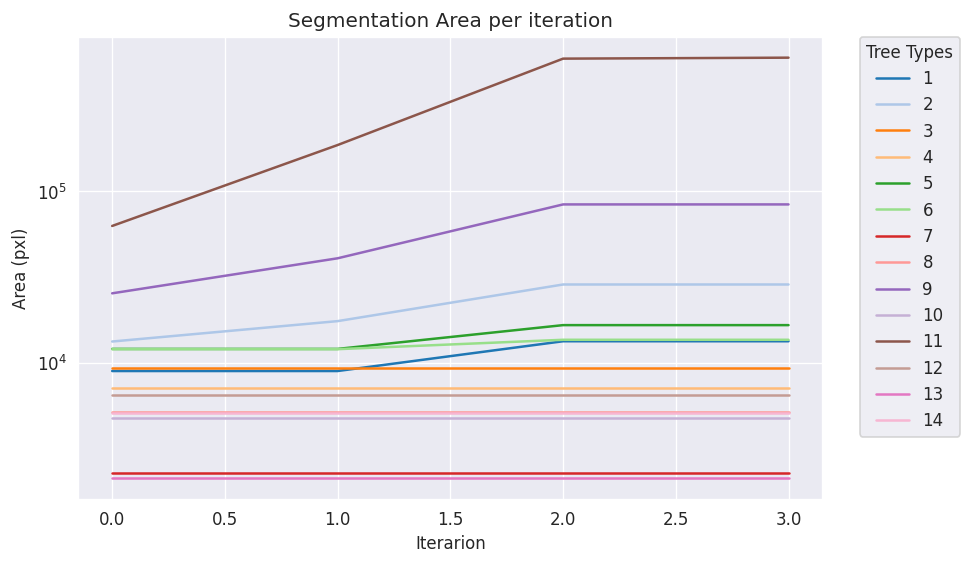

In [48]:
ax = sns.lineplot(
    data=selected_labels_stats,
    x="iter_num",
    y="area",
    hue="tree_type",
    estimator="sum",
    errorbar=None,
    palette=dict_colors["tree_type"],
)

ax.set_title("Segmentation Area per iteration")

# set y log scale
ax.set_yscale("log")

ax.set_ylabel("Area (pxl)")
ax.set_xlabel("Iterarion")

# set outside box legend
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, title="Tree Types")

plt.show()

Aqui temos um ponto preocupante. Em poucas árvores houve o avanço significativo da área segmentada.

# Contagem de árvores 

A partir das análise das áreas, identificamos que algumas classes ocuparam majoritariamente a área segmentada. Esse resultado pode ser negativo para nosso modelo, a menos que algumas espécies árvores, naturalmente, possuam copas maiores.

Diante disso, para analisar o desbalanceamento sem o viés da área, veremos a contagem das árvores por espécie.

In [49]:
print("Número total de árvores identificadas:")
print(last_iter_stats["label"].nunique())

Número total de árvores identificadas:
377


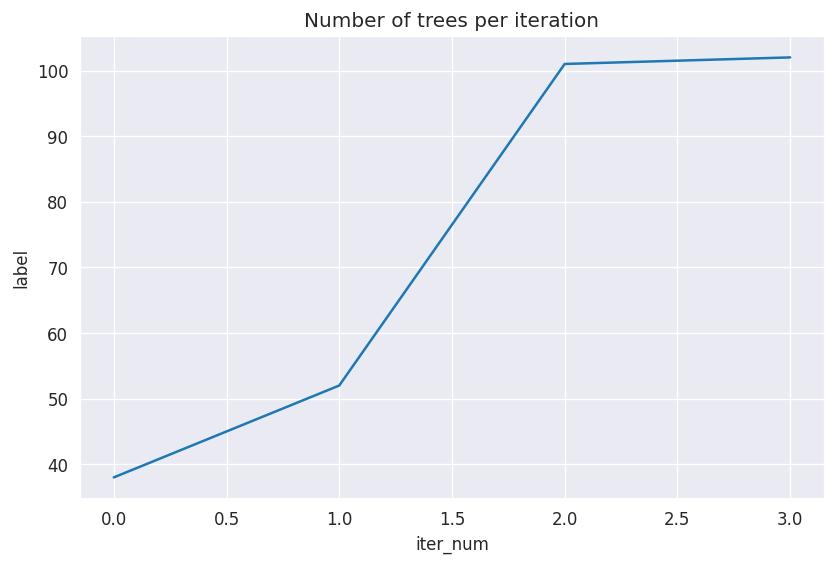

In [50]:
ax = sns.lineplot(
    data=selected_labels_stats, x="iter_num", y="label", estimator="nunique", errorbar=None
)

ax.set_title("Number of trees per iteration")

autolabel(ax, "{:.0f}")

plt.show()

Assim como na evolução da área por iteração, a contagem de árvores está começando a se estibilizar em um valor.

Porém, a evolução das contagem ainda está evoluindo mais rápido que área. Diante disso, podemos supor que nas últimas iterações o modelo estava evoluindo pouco na área porque estava focando mais nas árvores menores.

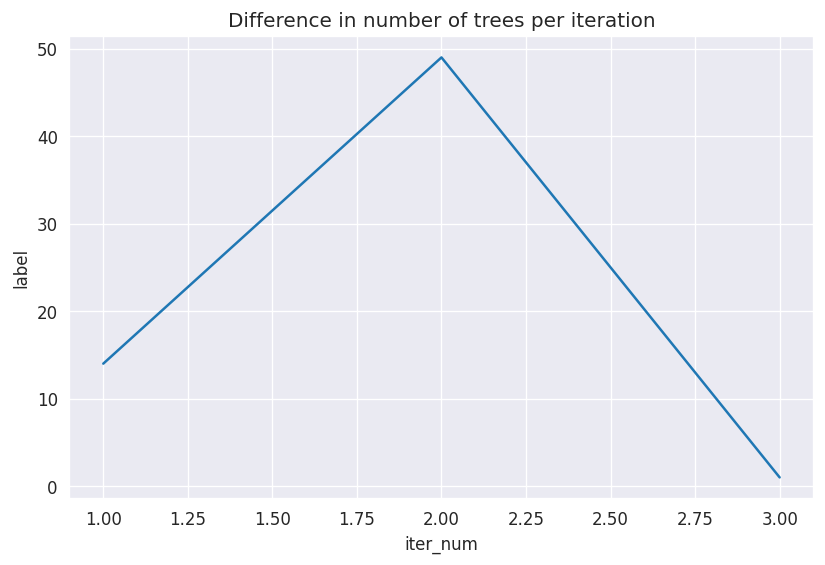

In [51]:
diff_n_labels = selected_labels_stats.groupby("iter_num")["label"].nunique().diff()

ax = sns.lineplot(data=diff_n_labels)

ax.set_title("Difference in number of trees per iteration")

plt.show()

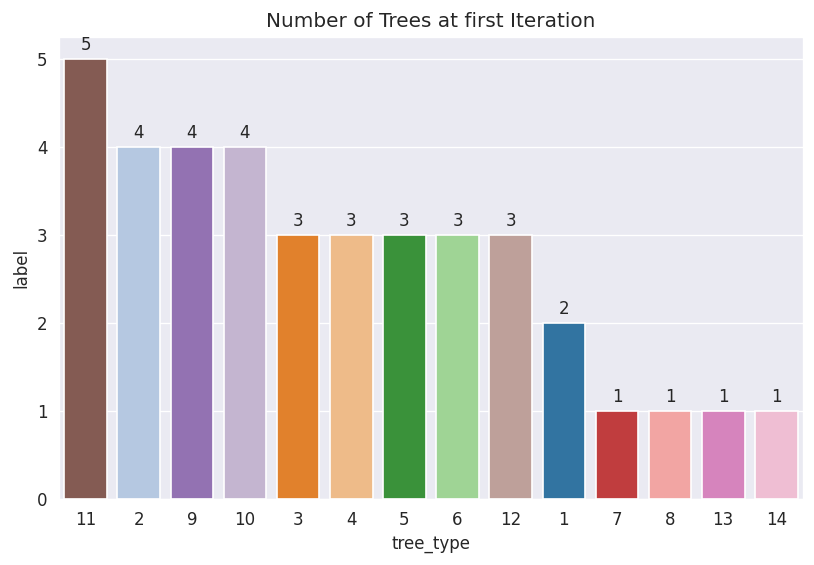

In [52]:
ax = sns.barplot(
    data=selected_labels_stats[selected_labels_stats["iter_num"] == 0],
    x="tree_type",
    y="label",
    estimator=lambda group: group.nunique(),
    errorbar=None,
    order=selected_labels_stats[selected_labels_stats["iter_num"] == 0]
            .groupby("tree_type")["label"]
            .nunique()
            .sort_values(ascending=False)
            .index,
    palette=dict_colors["tree_type"],
)

ax.set_title(f"Number of Trees at first Iteration")

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.0f}".format(y)))

autolabel(ax, "{:.0f}")

plt.show()

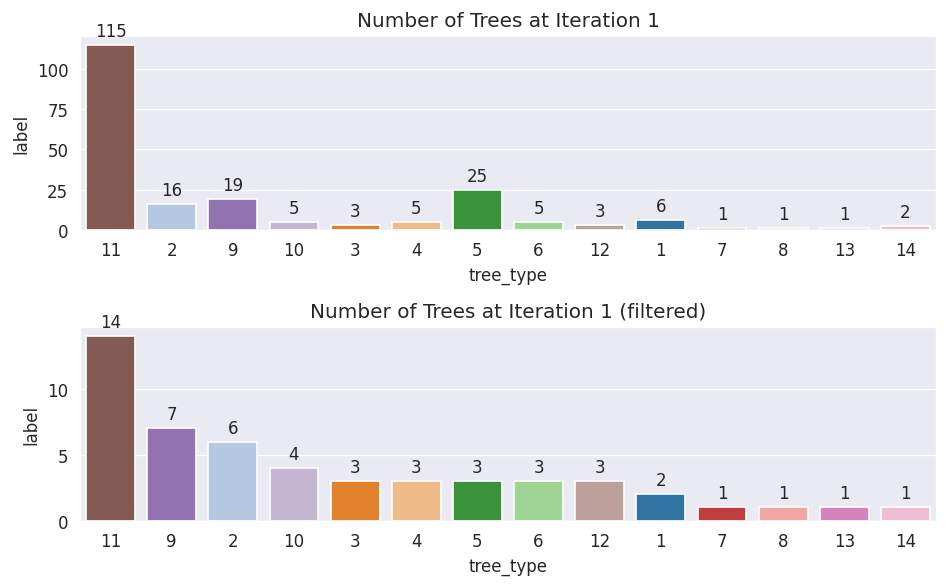

In [53]:
fig, ax =  plt.subplots(nrows=2, ncols=1)


sns.barplot(
    data=all_labels_stats[all_labels_stats["iter_num"] == 1],
    x="tree_type",
    y="label",
    estimator=lambda group: group.nunique(),
    errorbar=None,
    order=all_labels_stats[all_labels_stats["iter_num"] == 0].groupby("tree_type")["label"]
                                                            .nunique()
                                                            .sort_values(ascending=False)
                                                            .index,
    palette=dict_colors["tree_type"],
    ax=ax[0]
)

ax[0].set_title(f"Number of Trees at Iteration 1")

ax[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.0f}".format(y)))

autolabel(ax[0], "{:.0f}")


sns.barplot(
    data=selected_labels_stats[selected_labels_stats["iter_num"] == 1],
    x="tree_type",
    y="label",
    estimator=lambda group: group.nunique(),
    errorbar=None,
    order=selected_labels_stats[selected_labels_stats["iter_num"] == 1].groupby("tree_type")["label"]
                                                            .nunique()
                                                            .sort_values(ascending=False)
                                                            .index,
    palette=dict_colors["tree_type"],
    ax=ax[1]
)

ax[1].set_title(f"Number of Trees at Iteration 1 (filtered)")

ax[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.0f}".format(y)))

autolabel(ax[1], "{:.0f}")

plt.tight_layout()

plt.show()

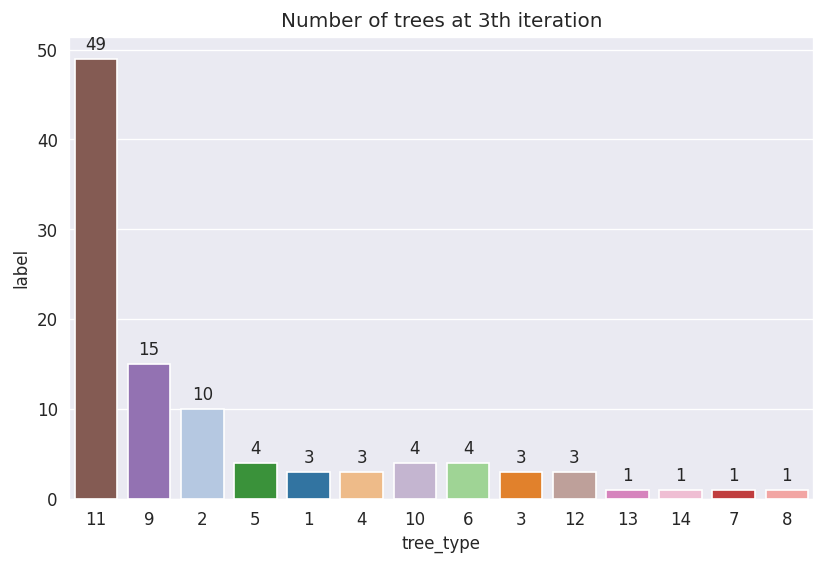

In [54]:
ax = sns.barplot(
    data=selected_labels_stats[selected_labels_stats["iter_num"]==selected_labels_stats["iter_num"].max()],
    x="tree_type",
    y="label",
    estimator=lambda group: group.nunique(),
    errorbar=None,
    order=last_iter_stats.groupby("tree_type")["label"]
    .nunique()
    .sort_values(ascending=False)
    .index,
    palette=dict_colors["tree_type"],
)

ax.set_title(
    f"Number of trees at {last_iter_stats['iter_num'].unique()[0]}th iteration"
)

autolabel(ax, "{:.0f}")

plt.show()

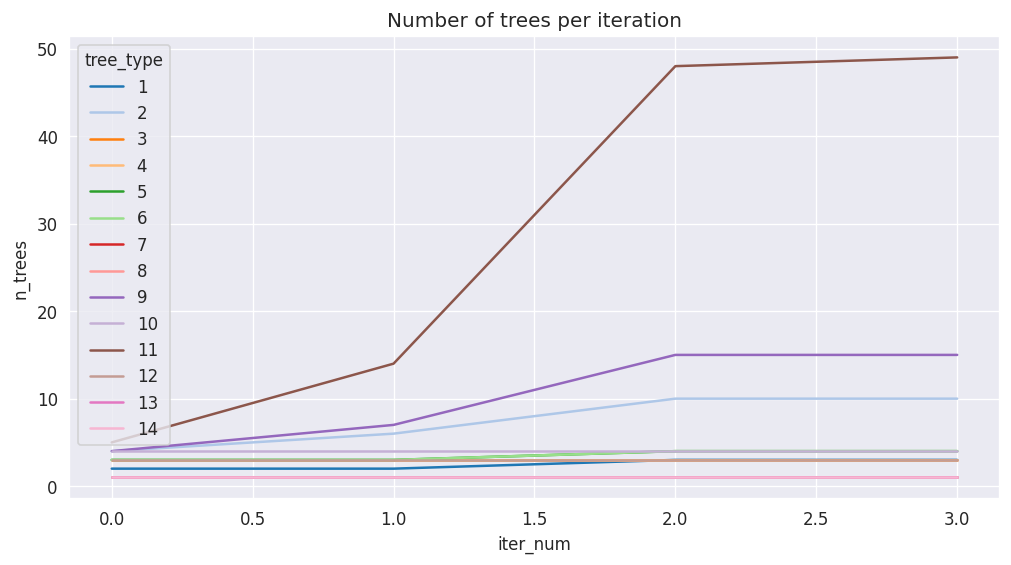

In [55]:
count_by_iter = selected_labels_stats.groupby(
    ["tree_type", "iter_num"], as_index=False, sort=True
)["label"].nunique()
count_by_iter.rename(columns={"label": "n_trees"}, inplace=True)

# change size fig
fig = plt.gcf()
fig.set_size_inches(10, 5)

ax = sns.lineplot(
    data=count_by_iter,
    x="iter_num",
    y="n_trees",
    hue="tree_type",
    errorbar=None,
    palette=dict_colors["tree_type"],
)

ax.set_title("Number of trees per iteration")

plt.show()

In [56]:
# !jupyter nbconvert "generate_results.ipynb" --no-input --no-prompt --to html --output-dir="../reports" --output="generate_results_V2.html"